In [1]:
# Other Imports.
from simple_rl.tasks import NavigationWorldMDP
from simple_rl.agents import QLearningAgent
from simple_rl.planning import ValueIteration
from simple_rl.tasks.grid_world.GridWorldStateClass import GridWorldState
from simple_rl.tasks.navigation.NavigationStateClass import NavigationWorldState

# Python Imports.
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Visualization functions 
import io
import imageio
from PIL import Image
from IPython import display

def read_pil_image_from_plt(plt):
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    return Image.open(buf)

def create_gif(img_generator, cmap=plt.cm.viridis, gif_name="./__gif_sample.gif", fps=10,
               figsize=(4, 4), title=None, display=False):
    with imageio.get_writer(gif_name, mode='I', fps=fps) as writer:
        for img in img_generator():
            # Append to GIF
            writer.append_data(np.array(img))
            
            # Wait to draw - only for online visualization
            if display:
                plt.imshow(img)
                display.clear_output(wait=True)
                display.display(plt.gcf())
        plt.clf()
    return

def trajetory_visualization(traj, nvmdp, Vg, steps=1000, figsize=(10,10)):
    
    N = min(steps, len(traj))  if steps else len(traj)
    for i in range(0, N):
        
        plt.close('all')
        plt.figure(figsize=figsize)
        
        nvmdp.visualize_grid(
            trajectories=[traj[:i+1]], show_colorbar=True, show_rewards_colorbar=True, goal_marker="*c", 
            new_fig=False, state_space_cmap=True, title="MDP", subplot_str="211", 
            end_marker="xk", traj_marker="-k")
        nvmdp.visualize_grid(
            Vg , trajectories=[traj[:i+1]], show_colorbar=True, show_rewards_colorbar=False, goal_marker="*c", 
            new_fig=False, state_space_cmap=False, title="Value", subplot_str="212",
            init_marker="go", init_marker_sz=20, end_marker="ro", traj_marker="-c", end_marker_sz=20, cmap="gray")
        yield read_pil_image_from_plt(plt)
        plt.clf()


def trajetory_list_visualization(traj_list, Vg_list, titles, nvmdp, max_steps=200, figsize=(10,10)):
    
    N = min(max([len(traj) for traj in traj_list]), max_steps)
    n_plots = len(traj_list)
    n_rows = int(np.ceil(np.sqrt(n_plots)))
    n_cols = int(np.ceil(n_plots / n_rows))
    for i in range(0, N):
        plt.close('all')
        plt.figure(figsize=figsize)
        for j, traj in enumerate(traj_list):
            nvmdp.visualize_grid(
                Vg_list[j], trajectories=[traj[:i+1]], show_colorbar=True, show_rewards_colorbar=False, 
                goal_marker="*c", new_fig=False, state_space_cmap=False, title=titles[j], subplot_str="{}{}{}".format(n_rows, n_cols, j+1),
                init_marker="go", init_marker_sz=20, end_marker="ro", traj_marker="-c", end_marker_sz=20)
        yield read_pil_image_from_plt(plt)
        plt.clf()
        
from matplotlib import colors as mcolors

colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
color_names = list(colors.keys())

## MDP

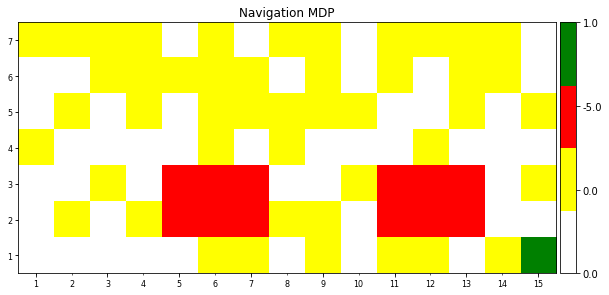

In [3]:
np.random.seed(0)
puddle = lambda x, y, w, h: [(x+i, y+j) for j in range(h) for i in range(w)]
c1, c2, g1, c_wall = (np.array([0, 0, 1., -5]) - 0) / 1.

def get_navmdp(noise):
    
    return NavigationWorldMDP(
        # MDP params
        width=15, height=7, 
        slip_prob=noise, step_cost=0.001, gamma=.99,
        # navigation cells
        nav_cell_types=['white', 'yellow', 'red'],
        nav_cell_rewards=[c1, c2, c_wall],
        nav_cell_p_or_locs=[0.5, 0.5, puddle(5,2,3,2) + puddle(11,2,3,2)],
        # goals
        goal_cell_locs=[[(15,1)]],
        goal_cell_rewards=[g1],
        goal_cell_types=["green"])

noise = 0.0
nvmdp = get_navmdp(noise=noise)
plt.figure(figsize=(10,10))
nvmdp.visualize_grid(new_fig=False, show_colorbar=True, show_rewards_colorbar=True, goal_marker="")

In [4]:
S = nvmdp.get_all_states()
s_to_idx = {(s[0],s[1]): idx for idx, s in enumerate(S)}
A = nvmdp.get_actions()
# r_min, r_max = -1, -0.01
# R_normal = [max(min(np.random.normal(-(r_max-r_min)/2., 0.01), r_max), r_min) for s in S]
# R_normal_fn = lambda s,a: R_normal[s_to_idx[tuple(s)]]
R_mdp = nvmdp.reward_func
R = R_mdp

T = nvmdp.transition_func
goal_idxs = [s_to_idx[p] for l in nvmdp.goal_cell_locs for p in l]
goal_rewards = nvmdp.goal_cell_rewards
pi_boltz = lambda Q, t: np.exp((1/t)*Q) / (np.exp((1/t)*Q).sum())
pi_greedy = lambda Q: np.eye(len(Q))[np.argmax(Q)]
pi_star = lambda s, Pi: np.random.choice(nvmdp.actions, p=Pi[s_to_idx[tuple(s)]])
pi_greedy_act = lambda s, Pi: nvmdp.actions[Pi[s_to_idx[tuple(s)]].argmax()]

## Value Iteration

In [5]:
def value_iter(S, A, R, T, gamma, policy, max_iters, eps=1e-9, given_goal_idxs=None, given_goal_rewards=[]):
     
    nS, nA = len(S), len(A)
    V = np.zeros((nS))
    Q = np.zeros((nS, nA))
    Pi = np.ones((nS, nA)) / nA
    s_to_idx = {(s[0],s[1]): idx for idx, s in enumerate(S)}
    
    if given_goal_idxs: # This isn't necessary when R is given
        for i, goal_idx in enumerate(given_goal_idxs):
            V[goal_idx] = 0
            
    for _iter in range(max_iters):
        
        V_copy = V.copy()
        for si, s in enumerate(S):
            if (goal_idxs and si in goal_idxs) or s.is_terminal():
                continue
            for ai, a in enumerate(A):
                s_prime_idx = s_to_idx[tuple(T(s,a))]
                Q[si,ai] = R(s,a) + gamma * V[s_prime_idx]
            Pi[si] = policy(Q[si,:])
            V[si] = Pi[si].dot(Q[si,:])
            
        if np.max(np.abs(V-V_copy)) <= eps:
            print("Converged at ", _iter)
            break
            
    return V, Pi, Q

def get_value_grid(V_array, nvmdp, s_to_idx):
    """Returns value over states space grid.
    """
    V = np.zeros((nvmdp.height, nvmdp.width), dtype=np.float32)
    for row in range(nvmdp.height):
        for col in range(nvmdp.width):
            x, y = nvmdp._rowcol_to_xy(row, col)
            si = s_to_idx[(x, y)]
            if si is not None:
                V[row, col] = V_array[si]
    return V

## Effects of boltzmann temperature & gamma

In [6]:
max_iters = 1000
eps = 1e-9
# pi_expl = pi_greedy
# pi_rollout = pi_greedy_act
pi_rollout = pi_star
n_traj = 1

In [7]:
exp_params = {"temp": [0.01, 10], 
              "gamma": [0.70, 0.99]}
V_list = []
Tau_list = []
titles = []
Pi_list = []

for temp in exp_params["temp"]:
    for gamma in exp_params["gamma"]:
        
        pi_expl = lambda Q: pi_boltz(Q, temp)
        print("Running VI: Temp {}, Gamma {}".format(temp, gamma))
        v, Pi, Q = value_iter(S, A, R, T, gamma, pi_expl, max_iters, eps, goal_idxs, goal_rewards)
        V = get_value_grid(v, nvmdp, s_to_idx)
        
        tau = nvmdp.sample_trajectories(
            n_traj, 1000, init_states=[(1,1)]*n_traj, init_cell_types=["white"], 
            init_unique=False, rand_init_to_match_n_traj=False, 
            policy=lambda s: pi_rollout(s, Pi))
        
        V_list.append(V)
        Pi_list.append(Pi)
        titles.append("Temp: {}, Gamma: {}".format(temp, gamma))
        Tau_list.append(tau[0][0])
        print("")

Running VI: Temp 0.01, Gamma 0.7
Converged at  29

Running VI: Temp 0.01, Gamma 0.99
Converged at  44

Running VI: Temp 10, Gamma 0.7
Converged at  37

Running VI: Temp 10, Gamma 0.99
Converged at  929



### Exploration

In [8]:
create_gif(lambda: trajetory_list_visualization(Tau_list, V_list, titles, nvmdp, max_steps=200, figsize=(20,10)),
           figsize=(40,10), fps=10, cmap=None, gif_name="./__gif_boltzmann_temp_gamma_effects_exploration.gif")

<Figure size 1440x720 with 0 Axes>

<img src="./__gif_boltzmann_temp_gamma_effects_exploration.gif">

### Greedy exploitation

In [9]:
pi_rollout = pi_greedy_act
Tau_list = []
for Pi in Pi_list:
        tau = nvmdp.sample_trajectories(
            n_traj, 1000, init_states=[(1,1)]*n_traj, init_cell_types=["white"], 
            init_unique=False, rand_init_to_match_n_traj=False, 
            policy=lambda s: pi_rollout(s, Pi))        
        Tau_list.append(tau[0][0])

In [ ]:
create_gif(lambda: trajetory_list_visualization(Tau_list, V_list, titles, nvmdp, max_steps=200, figsize=(20,10)),
           figsize=(40,10), fps=10, cmap=None, gif_name="./__gif_boltzmann_temp_gamma_effects_exploitation.gif")

<img src="./__gif_boltzmann_temp_gamma_effects_exploitation.gif">